Name: Sean Meade
    
Student ID: 10128921

## E-tivity 2: Neural Networks

In this E-tivity, we will be moving away from *regression* and get into *classification* with a simple artificial neural network (ANN) architecture. First, we will manually implement a *Perceptron* (a simple ANN with no hidden layer) to develop some familiarity with the various components of an ANN. Afterwards, we will use the Scikit-learn Python module (*sklearn*) to implement a slightly more complex ANN with less effort.

Note that in the first part of the E-tivity (the manual perceptron implementation), we won't bother with splitting the source data into training and testing to keep things simple. This is generally a *very bad idea* in machine learning, as you always want to evaluate a model's accuracy on unseen data. Unseen data is data that has not been used in the training nor preprocessing steps and is to ensure that your model isn't overfitting your training data. In the second part, we will take advantage of *sklearn* to do that.

Finally, we will briefly touch upon the concept of *feature engineering*, which is an important part of the machine learning process.


Please skim through the whole notebook before getting started, as some of the later tasks might influence your choice of design of the early parts.



Grading guidelines:

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=10674&rubricId=1010&originTool=quicklinks



**Tasks 1-3 are to be uploaded to locker. Task 4 should not be uploaded.**

### The data

The code cell below will generate you a random data set in which every observation is characterised by 3 features named $x$, $y$ and $Group$. $x$ and $y$ are continuous values, and $Group$ is a discrete value which can be either $1$ or $2$.

Our classification task will be to predict the value of $Group$ based on $x$ and $y$.

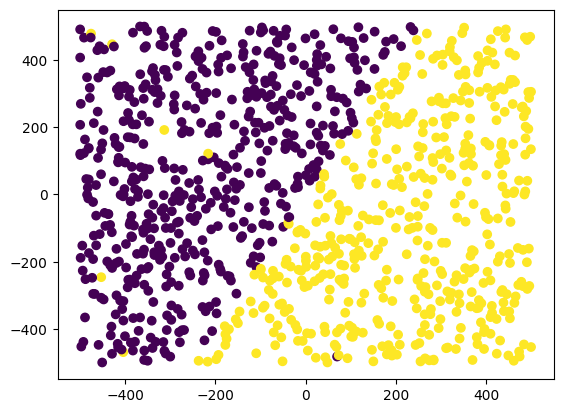

In [1]:
# Generate the source data

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

nsamples = 1000    # number of samples in data set
noiselevel = .01  # chance that a data point gets assigned with a reversed class than dictated by the model

# Create the input x and y values
x = np.random.rand(nsamples) * 1000 - 500
y = np.random.rand(nsamples) * 1000 - 500

# Categorize them into group one or two
Group = np.ones(nsamples)
for i in range(nsamples):
    if (4*x[i]-2*y[i]+.8 < 0):
        Group[i] = 1
    else:
        Group[i] = 2

# noisify the data
for i in range(nsamples):
    if np.random.rand() <= noiselevel:
        if Group[i] == 1:
            Group[i] = 2
        else:
            Group[i] = 1


Data = np.column_stack((x,y))

# let's plot it to get a visual impression
plt.scatter(x,y,c=Group)

### Task 1: Coding a Perceptron: going forward

#### Introduction
A Perceptron is an ANN with a single node. It uses $n$ input features, $n$ weights, a $bias$ term and an activation function to compute an output. The sum of the *x_i* input features multiplied by their respective *w_i* weights is then added to a $bias$ term before being passed to an activation function which gives us our final $output$:

$$output=ActivationF(bias+\sum\limits_{i=1}^{n}{x_i*w_i})$$



![Perceptron](perceptron.png)

Looking at our classification problem:
 * we have two input features: $x$ and $y$
 * we have one output feature: $Group$
 
Since our target output feature is discrete and binary (only two possible values), we want an activation function that will turn whichever continuous value is passed to it into something we can interpret as a probability of being in the first or second group. For this exercise, we will use the sigmoid function, which will provide us with a value between 0 and 1, and interpret this $output$ value as the probability that the input features belong to a data point for which $Group=2$. Since this is a binary classification problem, the probability that the input features belong to a data point for which $Group=1$ is $1-output$.

The sigmoid function is defined like this:
$$SigmoidF(x)=\frac{1}{1+e^{-x}}$$

In order to calculate $e^{-x}$, we can use the numpy *np.exp()* function.

So Which means our perceptron looks like this:

![Perceptron with input features x and y](perceptron_xy.png)



#### Coding tasks
 1. Implement a perceptron as defined above:
     * It should be defined with a set of weights equal to the number of input features and have a bias term.
     * It should have a sum function.
     * When given input features (or better, numpy arrays of input features), an evaluation function should be able to calculate a final output (or numpy array of outputs) between 0 and 1, which we will later fit (in Task 2) to the probability that the input(s) are from Group 2.
     * The activation function doesn't have to be a modular part of the definition of the perceptron: it can simply be hard coded as part of the evaluation function if you want, we are not writing an ANN library!
 2. Write a group prediction function that takes your perceptron's output value and converts it to a more readable group prediction: it should return 1 if $output<.5$, return 2 if $output>.5$ and 0 if $output=.5$ (if it's a 50/50, it effectively has no idea).
 3. Initialise your perceptron with random weights and a random bias term, run the source data through it. Use your group prediction function to compare predicted vs actual and evaluate how accurate is it.
 4. Plot your model's group predictions in similar fashion to the plot shown in the data generation in order to get a visual impression of your model.

In [2]:
def perception(inputs, weights, bias):

    """
    Pamas:
        input : A numpy.ndarray that contains numpy.ndarrays. The inner numpy.ndarray contain numpy.float64 and the number of elements is the number of input features.

    returns: 
        output: A numpy.ndarray containing numpy.float64 representing.

    Preforms a type of ANN called a perception using a sigmoid function as the activation function.
    
    """

    # sum the dot product of inputs and weights and add bias
    sum_data_dot_weights = np.dot(inputs, weights)
    add_bias = sum_data_dot_weights + bias

    # Use add_bias inside activation function (sigmoid)

    threshold = 20.0  # Adjust the threshold based on your needs

    output = []

    for elem in add_bias:
        # Piecewise linear approximation
        if elem > threshold:
            output.append(1.0)
        elif elem < -threshold:
            output.append(0.0)
        else:
            output.append(1.0 / (1.0 + np.exp(-elem)))

    return output


In [3]:
# Define the weights
weights = np.random.rand(len(Data[0]))

# Define bias
bias = np.random.rand()
output = perception(Data, weights, bias)

In [4]:
def prediction(probabilities):
    """
    Takes in a np.ndarray of probabilities that a point is in group 1 
    and returns an np.ndarray of what group it is probably in
    """
    group = []

    for prob in probabilities:
        if prob == 0.5:
            group.append(0)
        elif prob > 0.5:
            group.append(2)
        else:
            group.append(1)

    return np.array(group)

group = prediction(output)

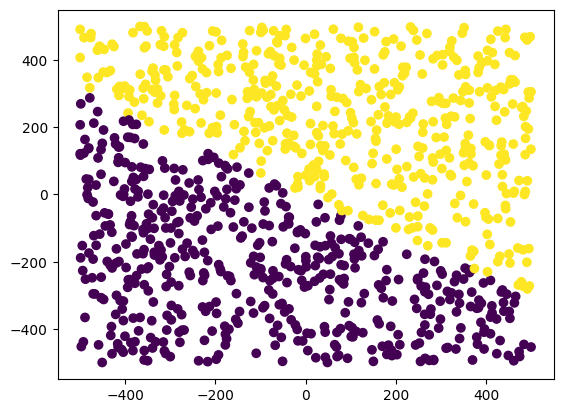

In [5]:
plt.scatter(x, y, c=group)
plt.show()

### Task 2: Coding a Perceptron: gradient descent

#### Introduction
Like for our polynomial model in the previous E-tivity, we will use gradient descent to update our weights and bias over a number iterations and slowly improve our model.

In order to implement a gradient descent, we will need a number of things:
 * a loss function
 * a way to calculate gradients for our weights/bias
 * a weights/bias update strategy

**Loss function:** rather than looking at the final class prediction, we will be looking at the model's output after the activation function. Since we defined that $[0,1]$ interval value as the probability that the input features correspond to Group 2, we want that value to be as close to $1$ as possible for Group 2 data points, and as close to $0$ as possible for Group 1 data points. Defining individual error as:

$$output_{actual}-output_{predicted}$$

We will keep things simple by simply defining our loss as the sum of squared errors, so for a training set of $n$ samples:

$$Loss=\sum\limits_{i=1}^{n}{{(output_{i_{actual}}-output_{i_{predicted}})}^2}$$

**Gradient calculation:** rather than using calculus, we will numerically evaluate our gradients. For a given weight $w$ and a small enough $\epsilon$ value, if we adjust $w$ by plus or minus $\epsilon$ and calculate the loss in both cases, we can compute the gradient like this:

$$gradient_w=\frac{Loss_{w+\epsilon}-Loss_{w-\epsilon}}{2\epsilon}$$

It's not terribly efficient to calculate our loss that many times with a slightly different model, but in this simple case it'll do just fine and will spare us the calculation of partial derivatives. As a side thought that is **not** part of the E-tivity: can you understand why/how this calculation works?

**Weight/bias update strategy:** as in our polynomial regression model, we will define a learning rate $lr$ and update each weight/bias in our perceptron using the following formula:
$$w_{new}=w_{current}-lr\times gradient_w$$

#### Coding tasks
 1. Implement a loss function using the sum of squared errors defined above.
 2. Implement a model update function that will calculate gradients for your perceptron's weights/bias and return you a new set of weights/bias that reduces loss. You can try starting with $lr=0.01$ and $\epsilon=0.01$.
 3. Verify that the new model has indeed reduced loss.
 4. Proceed to fit your model until you're happy with it. Do so by repeating the model update over a number of iterations until it hits your choice of stop condition.
 5. Evaluate your final model's accuracy and plot its predictions.

In [6]:
def loss(actual, predicted):
    """
    Takes in the np.ndarrays of the actual values and the predicted values and calculates and returns the result as a float
    """

    loss = np.sum(np.square(actual - predicted))

    return loss



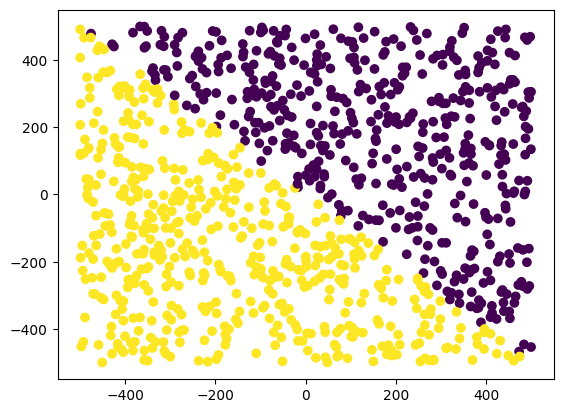

In [7]:
def improve_model(Data, Group, e = 0.01, lr = 0.01, iterations = 100000):
    calculated_loss = loss(Group-1, output)

    # Define the weights
    weights = np.random.rand(len(Data[0]))

    # Define bias
    bias = np.random.rand()

    # loop through and calculate the gradient weights bias and the new output data
    for i in range(iterations):
        gradient_w = ((calculated_loss + e) - (calculated_loss - e))/(2*e)
        weights = weights - (lr * gradient_w)
        bias = bias - (lr * gradient_w)
        output_new = perception(Data, weights, bias)
        calculated_loss = loss(Group-1, output_new)

        if calculated_loss < 10:

            return weights, bias, calculated_loss, prediction(output_new)
    
    return weights, bias, calculated_loss, prediction(output_new)

improved_model = improve_model(Data, Group)

plt.scatter(x, y, c=improved_model[3])
plt.show()

### Task 3: Scikit-learn

#### Introduction
Scikit-learn is a handy machine learning module for Python. It comes with plenty of functions to fit various types of models, as well as with general convenience tools such as splitting multi-featured data into training/testing partitions.

In the context of this E-tivity, we will be taking advantage of two things:
 * *sklearn.neural_network.MLPClassifier*: a class used to generate ANNs. MLP stands for Multi-layer Perceptron, which means that we will have to define at least one hidden layer of neurons in our network.
 * *sklearn.model_selection.train_test_split*: a function used to split data into training/testing partitions.

Documentation for these two can be found respectively at:
 * http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
 * http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Alternatively, type *MLPClassifier??* or *train_test_split??* in a code cell and run the cell to get the source code for these functions, which, conveniently, also contains some documentation.

**About train_test_split:** note that we will use the traditional notation that calls the array of input features $X$ and the array of actual outputs $Y$. These $X$ and $Y$ represent our inputs/outputs, and are not the same as the $x$ and $y$ arrays we defined originally. In fact we will define $X$ as a two dimensional array constructed from $x$ and $y$, while $Y$ will simply take the value of the $Group$ array.

**About hidden layers:** hidden layers are additional layers of nodes used in the calculation of the output. Each node is connected to a number of inputs which it will multiply by respective weights, add to a bias, and pass through an activation function. That output goes forward in the network, either to the final output node, or to another hidden layer. See the drawing below for an illustration of an ANN with two hidden layers of respective sizes 4 and 3. That's a lot more parameters to optimise than our simple perceptron, but it allows the model to fit much more complex relationships between the input features.

![ANN with 2 hidden layers](ann_2layers.png)

#### Coding tasks
The code below imports the required modules and defines the input data in the required shape. Complete it with additional code doing the following:
 1. Split X and Y into training and testing partitions, with 20% of the data for testing.
 2. Define a multi-layer perceptron with one hidden layer containing 2 nodes, a logistic sigmoid activation function, a stochastic gradient descent solver, a starting learning rate of 0.0001 and a batch size of 1.
 3. Fit the model to your *training* data
 4. Print out the mean accuracy of your model on the *testing* data.
 5. Plot the model's predictions on the *testing* data.

Score of classifier:  0.965


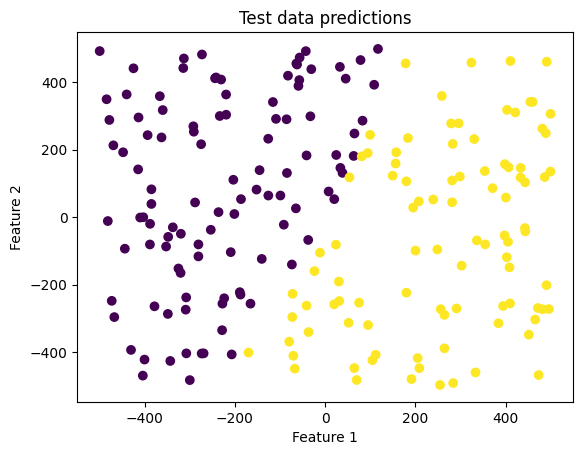

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# we define our input features as a single multi-dimensional array by 'stacking' them into columns
X = np.column_stack((x,y))
# we also define our output feature, simply for the sake of convenience
Y = Group

# split data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# define a new MLPClassifier
clf = MLPClassifier(
    hidden_layer_sizes=(2,),  # 1 hidden layer ha\ving 2 nodes
    activation='logistic',     # using a logistic sigmoid activation function
    solver='sgd',              # and a stochastic gradient descent solver
    learning_rate_init=0.0001,  # starting learning rate of 0.0001
    batch_size=1                # batch size of 1
)

# fit the classifier to the training data
clf.fit(X_train, y_train)


# print out mean accuracy of that trained model on the testing data
print("Score of classifier: ", clf.score(X_test, y_test))

# plot the model's predictions on the testing data
groups_predict = clf.predict(X_test)
x_test_points = X_test[:, 0]
y_test_points = X_test[:, 1]
plt.scatter(x_test_points, y_test_points, c=groups_predict)
plt.title("Test data predictions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


### Task 4: Model fitting challenge

**Important:** Note that your work on this task should **not** be posted publicly. This is an extra task that should only be submitted to Brightspace.

#### Introduction: feature engineering
In this final task, you will be given a data set and will have to try and fit it with an ANN. The challenge will come from the fact that while you will get data similar to what we used previously: two features $x$ and $y$, and a target output $group$, the value of $group$ has been calculated in a way that the ANN will not be naturally able to fit. This means that you will have to expand on the starting two features, through *feature engineering*.

Consider the data below:

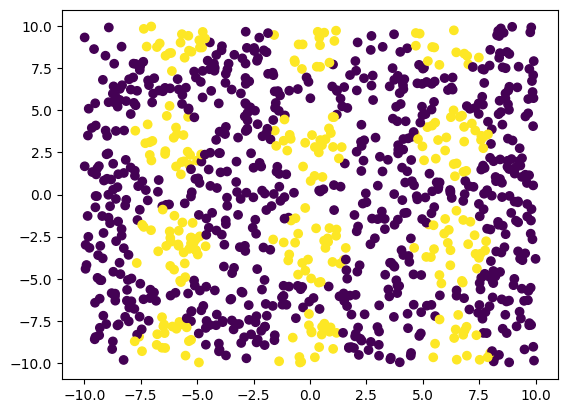

In [9]:
feateng_nsamples = 1000

feateng_x = np.random.rand(feateng_nsamples) * 20 - 10
feateng_y = np.random.rand(feateng_nsamples) * 20 - 10

feateng_group = np.ones(feateng_nsamples)

for i in range(feateng_nsamples):
    if ( 0.6*np.cos(feateng_x[i]) - 0.4*np.cos(feateng_y[i]) - .3 < 0):
        feateng_group[i] = 1
    else:
        feateng_group[i] = 2
        
feateng_data = np.column_stack((feateng_x, feateng_y, feateng_group))
plt.scatter(feateng_x, feateng_y, c=feateng_group)

The group of each observation (1 or 2, mapped to yellow and blue) is a direct function of the input features $x$ and $y$. But were we to try and train an ANN to fit the data, it'd have trouble fitting it well. A complex enough model with multiple hidden layers might be able to fit, but it probably wouldn't work out well for data generated in the same way but outside of the $[-10,10]$ interval used in training. This is because the data is based on $cos(x)$ and $cos(y)$, which can't easily be modelled through weighted sums of $x$ and $y$.

In order to find the best possible model, we would need to engineer two new features from the existing ones: from $x$ and $y$, we will generate $cos(x)$ and $cos(y)$:

In [10]:
feateng_cosx = np.cos(feateng_x)
feateng_cosy = np.cos(feateng_y)
feateng_data = np.column_stack((feateng_x, feateng_y, feateng_cosx, feateng_cosy, feateng_group))

If we use these 4 features to try and $group$, the ANN will have a far easier time. Instead of trying to predict $group$ simply from weighted sums of $x$ and $y$, the ANN will try to predict $group$ from weighted sums of $x$, $cos(x)$, $y$ and $cos(y)$. And it should quickly find that the best fit only uses $cos(x)$ and $cos(y)$, and converge until it finds the combination of weights and bias that work best. While this is **not** part of thie E-tivity, feel free to experiment on the side and try to fit an ANN to the data above, first only with $x$ and $y$, then with the enriched data. The latter should perform far better.

Of course, when trying to fit some data, you will rarely know in advance what specific features will lead to a better fit. So there is an exercise in trying to think of what the shape of the data might come from, as well as some trial and error generating additional features and trying to fit models. But the common thread of engineered features is that the ones likely to provide considerable improvements are the features that can't trivially be calculated from a weighted sum. There would be no point to create a feature for $2\times x$ and $3\times x$ for example, as the ANN will naturally try various weights to multiply $x$ by.

#### Introduction: the mystery data

In addition to this notebook, you should have been provided with the "t4_data.csv" CSV file. The code below will load that file as a numpy array and plot it. The data contains three columns: two features, and a target class. For plotting purposes we plot the first feature as $x$, the second feature as $y$, and colour the dots according to class.

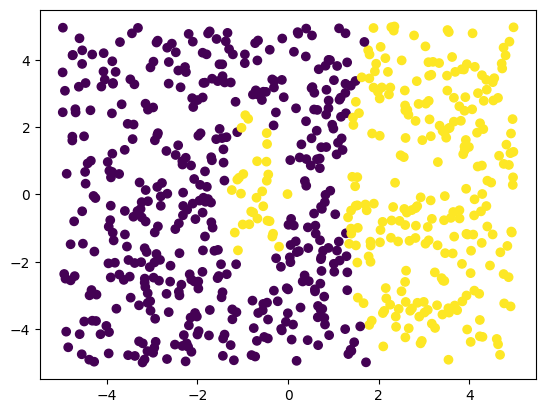

In [11]:
mydata = np.genfromtxt('t4_data.csv', delimiter=',')
plt.scatter(mydata[:,0], mydata[:,1], c=mydata[:,2])

#### Coding task
Your job is to use the sklearn MLPClassifier and train a model that can predict the class as accurately as possible.
 * You can play with the various options available in MLPClassifier (hidden layers, solver...).
 * It is recommended that you split your data into training/testing to avoid the risk of designing an overly complex model that overfits.
 * You only have two initial features, let's call them $x$ and $y$. These are unlikely to easily generate a good fitting model due to how the data was generated in the first place. You will need to either design a complex model, or do some clever feature engineering and create extra features out of these two. Think of what values based on $x$, $y$ or both wouldn't be naturally represented through a weighted sum, enrich your source data with these extra columns, and see if you can improve your classification.
 * Print out your final accuracy on training/testing data and plot your model's predictions also both on training/testing data.
 * Target is >95% accuracy over both sets, and in order to get the max grade of 20, you'll need to reach this with a single hidden layer.

Score of classifier 1: 0.9857142857142858


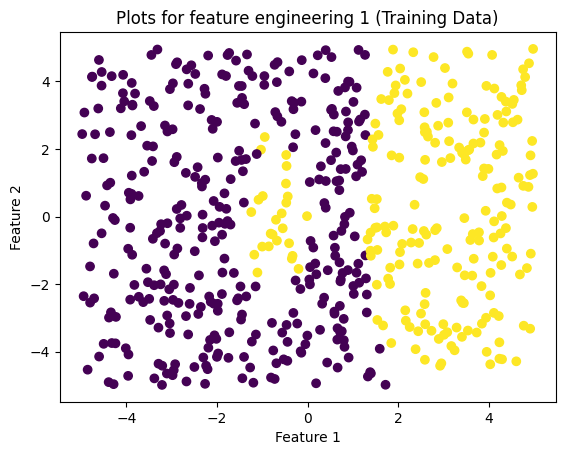

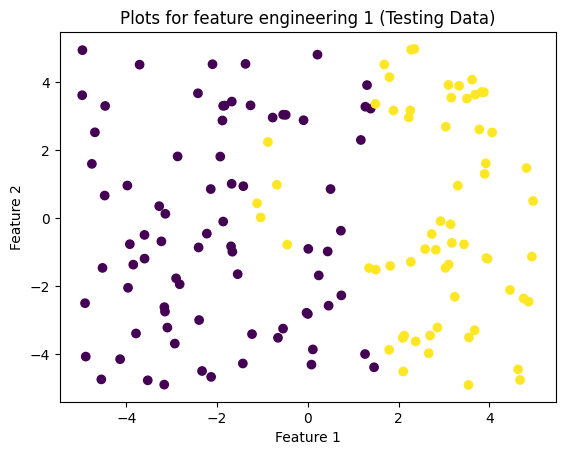

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Score of classifier 2: 0.9857142857142858


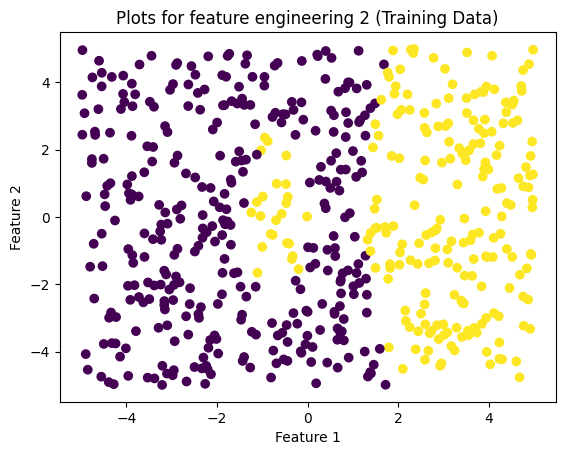

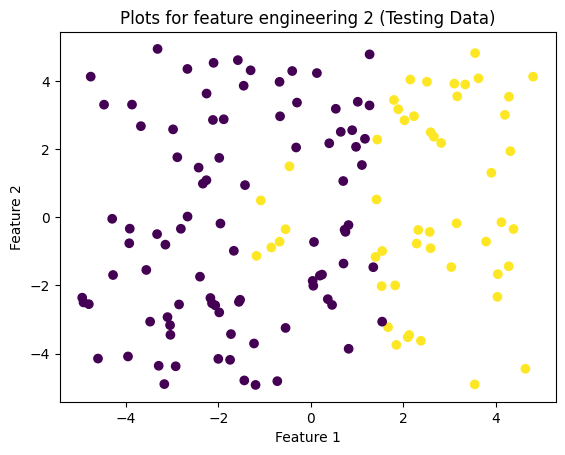

Score of classifier 3: 1.0


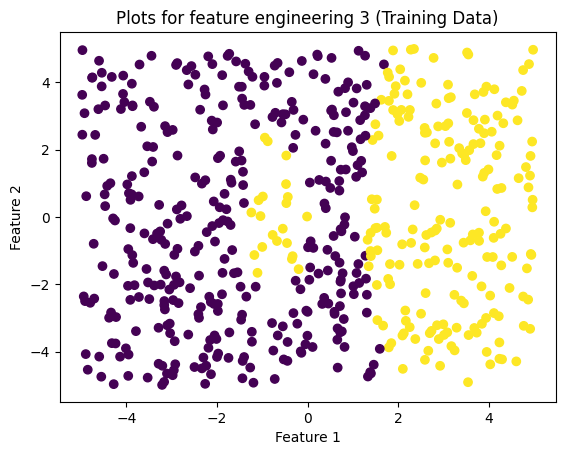

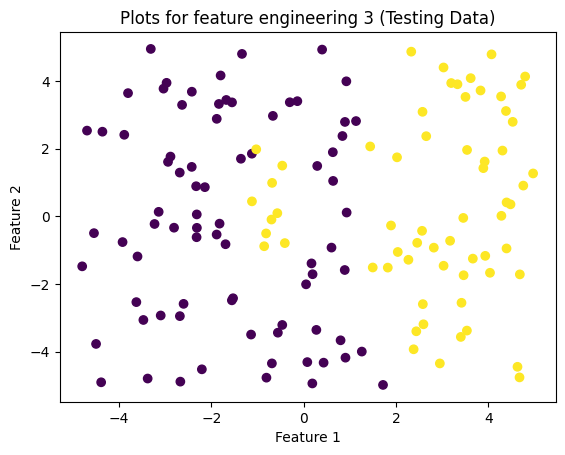

Score of classifier 4: 0.9785714285714285


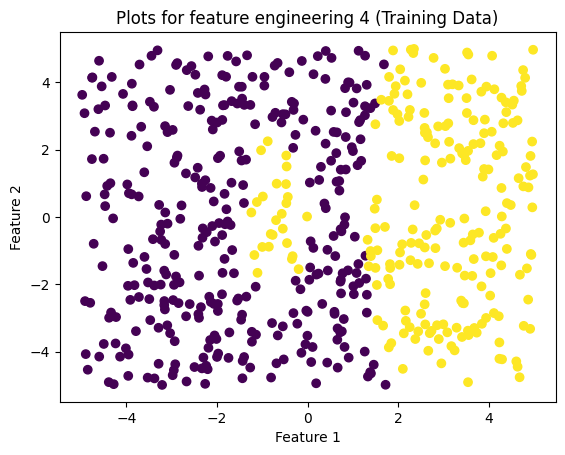

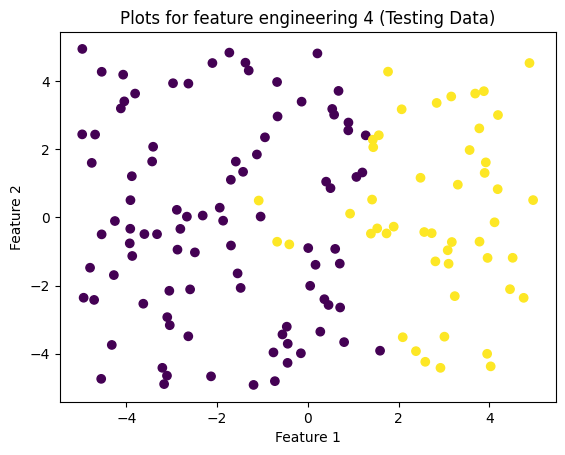

Score of classifier 5: 0.9714285714285714


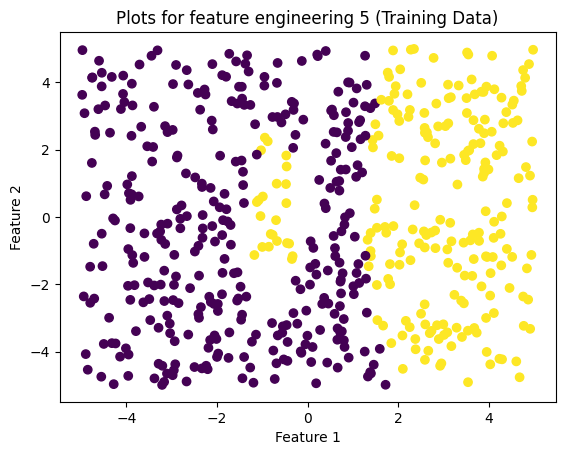

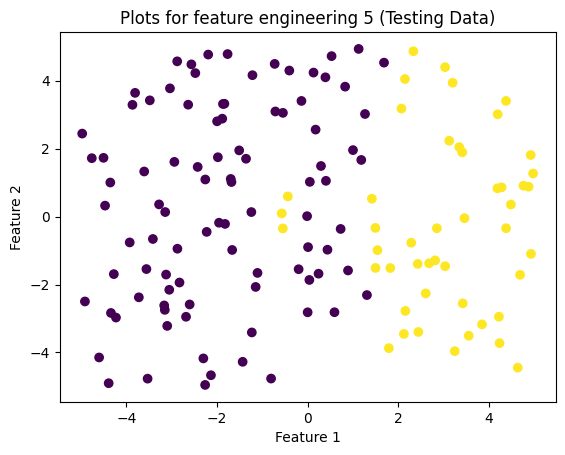

In [12]:
# Extracting features and labels from the dataset
X_mystery = mydata[:, 0]
Y_mystery = mydata[:, 1]
Groups_mystery = mydata[:, 2]

# Creating additional features based on original features
X_times_Y = X_mystery * Y_mystery
Y_times_X = Y_mystery * X_mystery
X_div_Y = X_mystery / Y_mystery
Y_div_X = Y_mystery / X_mystery
X_minus_Y = X_mystery - Y_mystery
Y_minus_X = Y_mystery - X_mystery
X_sqr = np.square(X_mystery)
Y_sqr = np.square(Y_mystery)

# Storing the different feature sets in a list
data_input = []
data_input.append(np.column_stack((X_mystery, Y_mystery)))
data_input.append(np.column_stack((X_mystery, Y_mystery, X_times_Y, Y_times_X)))
data_input.append(np.column_stack((X_mystery, Y_mystery, X_sqr, Y_sqr)))
data_input.append(np.column_stack((X_mystery, Y_mystery, X_div_Y, Y_div_X)))
data_input.append(np.column_stack((X_mystery, Y_mystery, X_minus_Y, Y_minus_X)))

# Loop over different feature sets
for i, feature_group in enumerate(data_input):

    # Define a new MLPClassifier
    clf_mystery = MLPClassifier(
        hidden_layer_sizes=(30, 10),  # 1 hidden layer having 2 nodes
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        max_iter=1000
    )

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feature_group, Groups_mystery, test_size=0.2)

    # Fit the classifier to the training data
    clf_mystery.fit(X_train, y_train)

    # Print out mean accuracy of that trained model on the testing data
    print(f"Score of classifier {i + 1}: {clf_mystery.score(X_test, y_test)}")

    # Plot the model's predictions on the training data
    plt.title(f"Plots for feature engineering {i + 1} (Training Data)")
    plt.scatter(X_train[:, :1], X_train[:, 1:2], c=y_train)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

    # Plot the model's predictions on the testing data
    plt.title(f"Plots for feature engineering {i + 1} (Testing Data)")
    plt.scatter(X_test[:, :1], X_test[:, 1:2], c=clf_mystery.predict(X_test))
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

## Reflection



First I created a number of features using featuring engineering. I then looped through them all splitting these with the original features to see the score of each.

To chose the MLPClassifier parameters I researched each one. They are listed below and my thoughts on them.

For activation: 

- 'identity': Useful to implement linear bottleneck. The relationship is not linear (or least not completely for some some points) so this would not be suitable.
- 'relu': ReLU has potential because it is non-linear activation function. Could possibly be a good option because of this.
- 'logistic': Sigmoid has potential because it is non-linear activation function.
- 'tanh': hyperbolic tan function seems to be used for problems where the input is centered around zero which our mystery data  is.

for solver (optimizer):

- 'lbfgs': used for small to medium-sized datasets the Broyden–Fletcher–Goldfarb–Shanno documentation mentions it is good for small datasets.
- 'sgd': normally used for large datasets the Stochastic Gradient Descent works in batches and this can help optimize for different datasets. We are using one dataset of (what I think is) a small to medium sized.
- 'adam': Adam Optimizer adapts the learning rates for each parameter individually, providing a robust and efficient optimization method. Suitable for a variety of optimization problems.

For my initial tests of all the feature engineering I used:
- hidden_layer_sizes=(30, 10)
    - Used a small size for hidden layers as I didn't want over fitting
- activation='tanh'
    - Because the input is centered around zero
- solver='adman'
    - Used for small to medium sized datasets
- learning_rate_init=adaptive
- max_iter=1000
    - because speed was not asked for


